In [1]:
import sys
from commonfunctions import *
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
from skimage.color import rgb2gray
from scipy.ndimage import interpolation as inter
from skimage.morphology import binary_erosion, binary_dilation

import cv2
from utlis import *

In [2]:
def skew_correction(image, showTrace):
        
    # correct skew
    def RotationAngle(binImg):
        def find_score(arr, angle):
            data = inter.rotate(arr, angle, reshape=False, order=0)
            hist = np.sum(data, axis=1)
            score = np.sum((hist[1:] - hist[:-1]) ** 2)
            return hist, score
        delta = 1
        limit = 50
        angles = np.arange(-limit, limit+delta, delta)
        scores = []
        for angle in angles:
            hist, score = find_score(binImg, angle)
            scores.append(score)
        best_score = max(scores)
        best_angle = angles[scores.index(best_score)]
        return best_angle

    def RotateImage(thresh2,angle):
        (h, w) = thresh2.shape
        (cX, cY) = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
        rotated_image = cv2.warpAffine(thresh2, M, (w, h),borderMode=cv2.BORDER_CONSTANT,borderValue=(255,255,255))
        return rotated_image

    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, 11, 5) # increasing box size will make elements delated in high ratio
    rotated = RotateImage(thresh2,RotationAngle(thresh2))
    if(showTrace):
        show_images([rotated])
    
    return rotated

In [3]:
def trepozoidal_correction(image, showTrace): 
    # Image modification
    img_original = image.copy()
    img = image.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 50, 15, 15)
    edged = cv2.Canny(gray, 50, 50)
    kernel = np.ones((7, 7))
    dilatedImg = cv2.dilate(edged, kernel, iterations=2)
    edged = cv2.erode(dilatedImg, kernel, iterations=1)
    # cv2.imwrite("mine.jpg",edged)


    # Contour detection
    contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ContourFrame = img.copy()
    ContourFrame = cv2.drawContours(ContourFrame, contours, -1,  (0, 255, 0), 10)

    biggest, max_area = biggestContour(contours)

    new_img = cv2.drawContours(img, [biggest], -1, (0, 255, 0), 3)
    if(showTrace): show_images([ContourFrame,new_img])

    # Pixel values in the original image
    points = biggest.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")

    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]

    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]

    (top_left, top_right, bottom_right, bottom_left) = input_points
    bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
    right_height = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
    left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

    # Output image size
    max_width = max(int(bottom_width), int(top_width))
    # max_height = max(int(right_height), int(left_height))
    max_height = int(max_width * 1.414)  # for A4

    # Desired points values in the output image
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

    # Perspective transformation
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_output = cv2.warpPerspective(img_original, matrix, (max_width, max_height))

    # Image shape modification for hstack
    gray = np.stack((gray,) * 3, axis=-1)
    edged = np.stack((edged,) * 3, axis=-1)

    if(showTrace):
        show_images([img_original, gray, edged])
        show_images([ContourFrame])
        show_images([ img, img_output])
    return img_output

In [4]:
def CheckAlgo(image,showTrace):
    img = cv2.resize(image, (480*2, 640*2))
    imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    imgThre= cv2.adaptiveThreshold(imgGray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
       cv2.THRESH_BINARY_INV, 1001, 5)

    imgThre2 = cv2.bitwise_not(imgThre)
    imgThre3 =cv2.medianBlur(imgThre2,3)
    w, h = imgThre3.shape

    if(showTrace):
        show_images([img,imgThre,imgThre2,imgThre3]) 

    top = np.sum(imgThre3[0:20, 0:h])/(20*h)
    bottom = np.sum(imgThre3[w-20:w, 0:h])/(20*h)
    right = np.sum(imgThre3[0:w, 0:20])/(20*w)
    left = np.sum(imgThre3[0:w, h-20:h])/(20*w)
    check = (top+bottom+right+left)/4
    return check

In [18]:
#initializing
def preprocessing (image, showTrace = False):
    check = CheckAlgo(image,showTrace)
    if(check<100):
        img = trepozoidal_correction(image, showTrace)
        # img = trap(image)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img= cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 51, 12)
    else:
        img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        img= cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 101, 12)
        # img = skew_correction(image, showTrace)
    return img

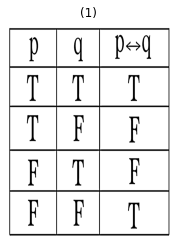

[array([  34, 3173, 2423, 3173], dtype=int32), array([  35,   92, 2422,   92], dtype=int32), array([  41, 3196, 2416, 3196], dtype=int32), array([  47, 1929, 2410, 1929], dtype=int32), array([  48,  685, 2409,  685], dtype=int32), array([  49,  114, 2409,  114], dtype=int32), array([  47, 2518, 2389, 2518], dtype=int32), array([  48, 1273, 2409, 1273], dtype=int32), array([  47, 1251, 2387, 1251], dtype=int32), array([  48, 2540, 2409, 2540], dtype=int32), array([ 768, 1906, 2394, 1906], dtype=int32), array([ 771,  662, 2410,  662], dtype=int32)]
[[  34 2423 3173 3173]
 [  35   92   92 2422]
 [  41 2416 3196 3196]
 [  47 1929 1929 2410]
 [  48  685  685 2409]
 [  49  114  114 2409]
 [  47 2389 2518 2518]
 [  48 1273 1273 2409]
 [  47 1251 1251 2387]
 [  48 2409 2540 2540]
 [ 768 1906 1906 2394]
 [ 662  662  771 2410]]
12


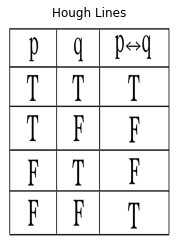

In [56]:
img = cv2.imread("table extraction/table_images/table8.png")
# img = cv2.imread("grade sheet/2.jpg") 
img = cv2.resize(img, (2448, 3264)) # size of A4
img = img.astype(np.uint8)
img = preprocessing(img, showTrace=False)
cv2.imwrite("printed.jpg",img)
show_images([img])
edged = cv2.Canny(img, 50, 150)
lines = cv2.HoughLinesP(edged,rho =5,theta = 1*np.pi/180,threshold = 50,minLineLength = 200,maxLineGap = 50)
N = lines.shape[0]
counter = 0 
h_lines  = []
for i in range(N):
    if lines[i][0][1] == lines[i][0][3]:
        x1 = lines[i][0][0]
        y1 = lines[i][0][1]    
        x2 = lines[i][0][2]
        y2 = lines[i][0][3]    
        cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)
        counter = counter + 1
        h_lines.append(lines[i][0])

print(h_lines)

print(sorted)
print(counter)
plt.figure(),plt.imshow(img),plt.title('Hough Lines'),plt.axis('off')
plt.show()